In [1]:
import os
import sys

if os.environ['PY_SOURCES'] not in sys.path:
    sys.path.append(os.environ['PY_SOURCES'])

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext rpy2.ipython

In [2]:
import IPython
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [3]:
from rpy2 import robjects
from rpy2.robjects.lib import ggplot2
from rpy2.robjects.lib import grdevices

robjects.pandas2ri.activate()

Lib rpy2 needs a fix:
https://bitbucket.org/rpy2/rpy2/issues/398/pandas2ri-conversion-does-not-work-for    
https://bitbucket.org/rpy2/rpy2/commits/6507a43d2793
   
```
- res.rclass = StrSexpVector('ordered', 'factor')
+ res.rclass = StrSexpVector(('ordered', 'factor'))

```

In [5]:
# should be no error
category = pd.Series(pd.Categorical(['a','b','c','a'],
                     categories=['a','b','c'],
                     ordered=True))
robjects.conversion.py2ro(category)

a,b,c,a


In [17]:
import kaggle.house_prices.helpers as helpers

combined_dataset = helpers.load_data()

combined_dataset.shape
combined_dataset[combined_dataset['dataSource'] == 'train'].shape
combined_dataset[combined_dataset['dataSource'] == 'test'].shape

(2919, 82)

(1460, 82)

(1459, 82)

In [25]:
character_colnames =helpers.get_character_colnames(combined_dataset)
numeric_colnames = helpers.get_numeric_colnames(combined_dataset)

len(character_colnames)
len(numeric_colnames)

print(character_colnames)
print(numeric_colnames)

45

35

['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice', 'Scre

In [29]:
categ_data = combined_dataset[character_colnames + ['SalePrice']]#.fillna('__missing__')
numeric_data = combined_dataset[numeric_colnames]

In [30]:
categ_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 46 columns):
Alley            198 non-null object
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtQual         2838 non-null object
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non-null object
Fence            571 non-null object
FireplaceQu      1499 non-null object
Foundation       2919 non-null object
Functional       2917 non-null object
GarageCond       2760 non-null object
GarageFinish     2760 non-null object
GarageQual       2760 non-null object
GarageType       2762 non-null object
Heating          2919

In [31]:
numeric_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 35 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtUnfSF        2918 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2918 non-null float64
GarageCars       2918 non-null float64
GarageYrBlt      2760 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2433 non-null float64
LowQualFinSF     2919 non-null int64
MasVnrArea       2896 non-null float64
MiscVal          2919 non-null int64
OpenPorchSF      2919 

# Entropy

In [33]:
import kaggle.house_prices.attributes_selection as attr_sel

In [42]:
categ_vars_by_entropy = (
    attr_sel.arrange_vars_by_entropy(
        categ_data.drop('SalePrice', 1)
    )
)

categ_vars_by_entropy.head()
categ_vars_by_entropy.tail()

,var,entropy
0,Utilities,0.012627
1,PoolQC,0.038203
2,Street,0.038504
3,Condition2,0.106434
4,RoofMatl,0.138519


,var,entropy
40,Exterior1st,2.723429
41,Exterior2nd,2.800720
42,MSSubClass,2.920021
43,MoSold,3.393870
44,Neighborhood,4.212100


In [43]:
numeric_vars_by_entropy = (
    attr_sel.arrange_vars_by_entropy(
        numeric_data.drop('SalePrice', 1)
    )
)
    
numeric_vars_by_entropy.head()
numeric_vars_by_entropy.tail()

,var,entropy
0,PoolArea,0.057677
1,3SsnPorch,0.158769
2,LowQualFinSF,0.173265
3,KitchenAbvGr,0.280959
4,BsmtHalfBath,0.344808


,var,entropy
29,TotalBsmtSF,9.348757
30,BsmtUnfSF,9.390885
31,1stFlrSF,9.601608
32,GrLivArea,9.882939
33,LotArea,10.400602


# Normal Paper

In [46]:
target_normal_paper = pd.melt(
    (
        combined_dataset[['SalePrice']]
        .dropna()
        .rename(
            columns={"SalePrice": "price"}
        )
        .assign(
            price_log = lambda df: np.log(df.price)
        )
    ), 
    var_name='var', 
    value_name='value'
).assign(
    normed_value = lambda df: (
        df.groupby('var', group_keys=False)
          .apply(
              lambda df: (df.value - np.mean(df.value)) / np.std(df.value, ddof=1)
          )
    )
)

(target_normal_paper
    .sort_values(['var', 'value'])
    .groupby('var')
    .tail(3)
)

,var,value,normed_value
1169,price,625000.000000,5.589940
1182,price,745000.000000,7.100466
691,price,755000.000000,7.226343
2629,price_log,13.345507,3.308173
2642,price_log,13.521139,3.747857
2151,price_log,13.534473,3.781237


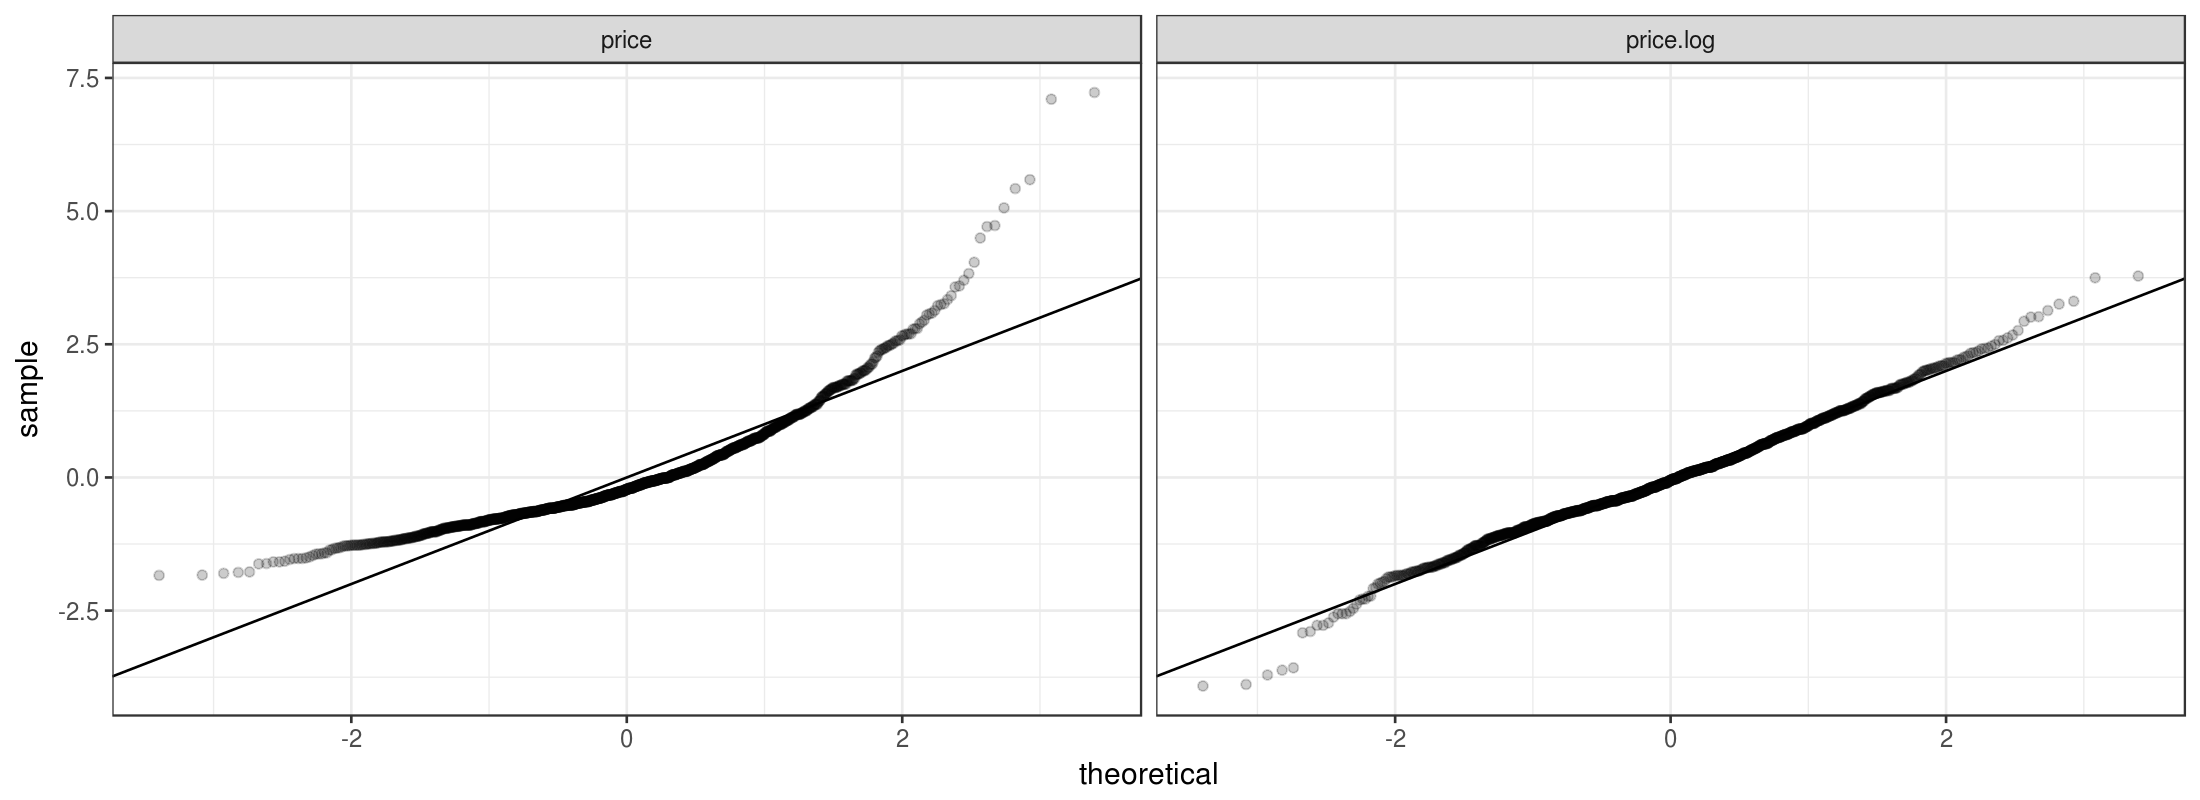

In [22]:
with grdevices.render_to_bytesio(grdevices.png, width=2200, height=800, res=180) as img:
    g = (
        ggplot2.ggplot(target_normal_paper) +
        ggplot2.stat_qq(ggplot2.aes_string(sample='normed_value'), alpha=0.2) +
        ggplot2.facet_wrap(robjects.Formula('~var'), ncol=2) +
        ggplot2.geom_abline(slope=1) +
        ggplot2.theme_bw()
    )
    print(g)

from IPython.display import Image, display
data = img.getvalue()
display(Image(data=data, format='png', embed=True))

In [95]:
class CategVarsVsTarget:
    def __init__(self, categ_data):
        self.categ_data = categ_data
        self.long = None
        self.precalculated = None
        self.global_std = np.std(categ_data['SalePrice'], ddof=1)
    
    def calc_std(self, vec):
        if len(vec) == 1:
            return self.global_std
        if len(vec) > 1:
            return np.std(vec, ddof=1)
        
    def get_long(self):
        if self.long:
            return self.long
        
        df = self.categ_data.dropna(subset=['SalePrice']).fillna('__missing__')
        
        self.long = pd.melt(
            frame=df, 
            id_vars=['SalePrice'], 
            var_name='var', 
            value_name='value'
        )
        return self.long
        
    def get_precalculated(self):
        """
            Pandas group by is not a friend with NaN. 
            So all NaNs are replaced with string `__missing__`.
        """
        if self.precalculated:
            return self.precalculated
        global_std = self.categ_data['SalePrice'].std()

        long = self.get_long().groupby(['var', 'value'])

        long = long.agg({
            'SalePrice': [('n',    np.count_nonzero), 
                          ('mean', np.mean), 
                          ('std',  lambda vec: self.calc_std(vec))]}
        )

        long.columns = long.columns.get_level_values(1)

        long = (long
                .assign(freq = long.groupby('var')['n'].apply(lambda n: n / np.sum(n)))
                .reset_index()
                .sort_values(['var', 'mean']))

        grp = long.groupby(['var'], group_keys=False)
        long['lead_mean'] = grp.apply(lambda df: df['mean'].shift(-1))
        long['lead_freq'] = grp.apply(lambda df: df['freq'].shift(-1))
        long['lead_std'] = grp.apply(lambda df: df['std'].shift(-1))
        
        self.precalculated = long
        return self.precalculated
    
    def get_separation(self):
        return (
            self.get_precalculated()
                .assign(additive = self.calc_additive)
                .groupby(['var'], group_keys=False)
                ['additive']
                .sum()
                .sort_values()
                .to_frame('score')
                .reset_index()
        )
    
    @staticmethod    
    def calc_additive(df):
        up = (df['lead_mean'] - df['mean'])**2
        down = df['std']**2 / df['freq'] + df['lead_std']**2 / df['lead_freq']
        return up / down

precalculated = CategVarsVsTarget(categ_data).get_precalculated()
categ_vars_by_target_separation = CategVarsVsTarget(categ_data).get_separation()

precalculated.head(10)

,var,value,n,mean,std,freq,lead_mean,lead_freq,lead_std
0,Alley,Grvl,50.0,122219.080000,34780.780734,0.034247,168000.585366,0.028082,38370.375243
1,Alley,Pave,41.0,168000.585366,38370.375243,0.028082,183452.131483,0.937671,80667.145180
2,Alley,__missing__,1369.0,183452.131483,80667.145180,0.937671,NaN,NaN,NaN
4,BldgType,2fmCon,31.0,128432.258065,35458.545158,0.021233,133541.076923,0.035616,27833.249197
5,BldgType,Duplex,52.0,133541.076923,27833.249197,0.035616,135911.627907,0.029452,41013.222080
6,BldgType,Twnhs,43.0,135911.627907,41013.222080,0.029452,181959.342105,0.078082,60626.108918
7,BldgType,TwnhsE,114.0,181959.342105,60626.108918,0.078082,185763.807377,0.835616,82648.502922
3,BldgType,1Fam,1220.0,185763.807377,82648.502922,0.835616,NaN,NaN,NaN
10,BsmtCond,Po,2.0,64000.000000,4242.640687,0.001370,105652.891892,0.025342,29278.694797
12,BsmtCond,__missing__,37.0,105652.891892,29278.694797,0.025342,121809.533333,0.030822,43467.796975


In [96]:
categ_vars_by_target_separation.head()

,var,score
0,Utilities,0.000205
1,LotConfig,0.000507
2,Functional,0.000648
3,PoolQC,0.001066
4,Condition2,0.001223


In [97]:
categ_vars_by_target_separation.tail()

,var,score
39,CentralAir,0.204230
40,GarageFinish,0.275604
41,BsmtQual,0.421098
42,KitchenQual,0.477529
43,ExterQual,0.487153


In [26]:
def order_factor_by_target(df, factor_var, target_var):
    """XXX"""
    tmp = (
        categ_data
        .dropna(subset=[target_var])
        [[target_var, factor_var]]
    )

    factor_ordering = (
        tmp
        .groupby(factor_var, as_index=False)
        .agg(np.mean)
        .sort_values(target_var)
        [factor_var]
    )

    tmp = (
        tmp
        .assign(**{factor_var: (
            lambda df: df[factor_var]
                       .astype('category')
                       .cat.reorder_categories(factor_ordering, ordered=True))
        })
    )    
    return tmp

x = order_factor_by_target(categ_data, 'ExterQual', 'SalePrice')
x['ExterQual'].dtype

CategoricalDtype(categories=['Fa', 'TA', 'Gd', 'Ex'], ordered=True)

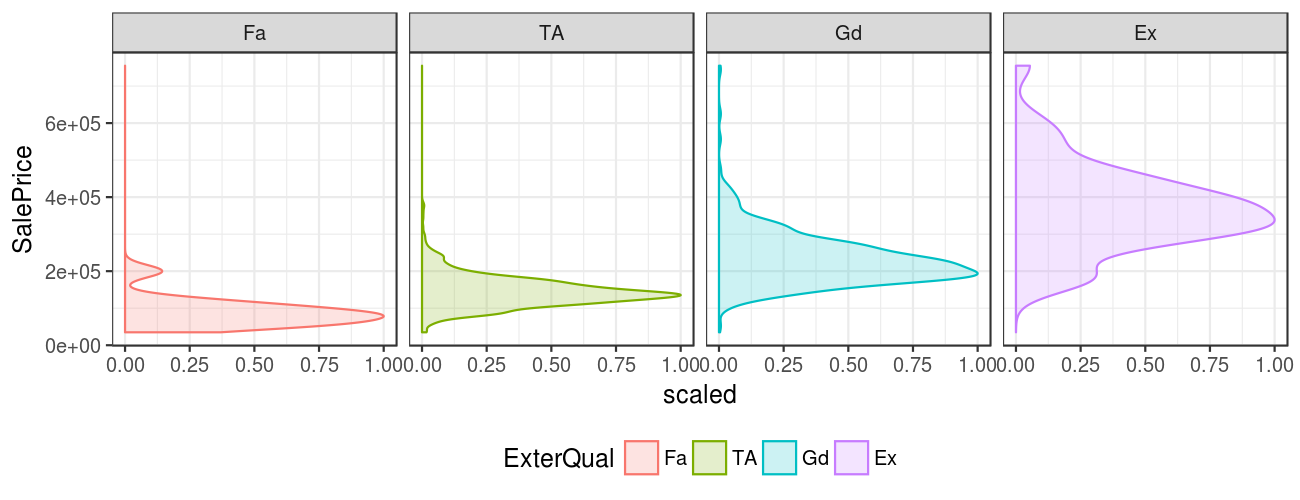

In [121]:
df = order_factor_by_target(categ_data, 'ExterQual', 'SalePrice')

with grdevices.render_to_bytesio(grdevices.png, width=1300, height=500, res=150) as img:
    g = ggplot2.ggplot(df) + \
    ggplot2.aes_string(x='SalePrice', color='ExterQual') + \
    ggplot2.geom_density(ggplot2.aes_string(y='..scaled..', fill='ExterQual'), alpha=0.2) + \
    ggplot2.facet_wrap(robjects.Formula('~ ExterQual'), nrow=1) + \
    ggplot2.coord_flip() + \
    ggplot2.theme_bw() + \
    ggplot2.theme(**{'legend.position': 'bottom'})
    print(g)

from IPython.display import Image, display
data = img.getvalue()
display(Image(data=data, format='png', embed=True))

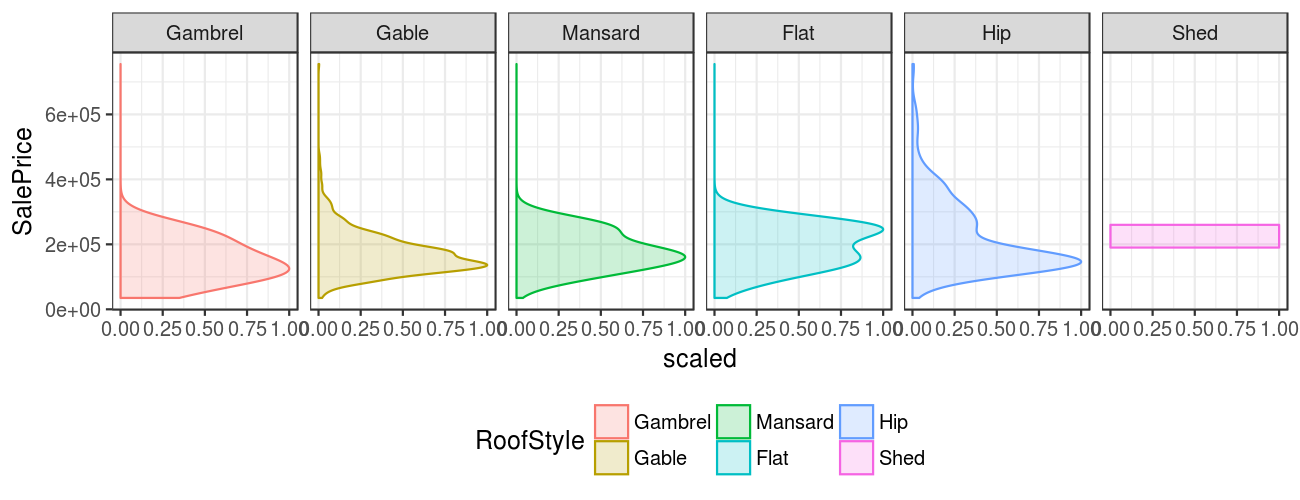

In [120]:
df = order_factor_by_target(categ_data, 'RoofStyle', 'SalePrice')

with grdevices.render_to_bytesio(grdevices.png, width=1300, height=500, res=150) as img:
    g = ggplot2.ggplot(df) + \
    ggplot2.aes_string(x='SalePrice', color='RoofStyle') + \
    ggplot2.geom_density(ggplot2.aes_string(y='..scaled..', fill='RoofStyle'), alpha=0.2) + \
    ggplot2.facet_wrap(robjects.Formula('~ RoofStyle'), nrow=1) + \
    ggplot2.coord_flip() + \
    ggplot2.theme_bw() + \
    ggplot2.theme(**{'legend.position': 'bottom'})
    print(g)

from IPython.display import Image, display
data = img.getvalue()
display(Image(data=data, format='png', embed=True))

In [103]:
categ_vars_by_r2 = (
    pd.melt(
        frame=categ_data.dropna(subset=['SalePrice']), 
        id_vars=['SalePrice'], 
        var_name='var', 
        value_name='value'
    )
    .groupby('var')
    .apply(
        lambda df: smf.ols(formula='SalePrice ~ value', data=df).fit().rsquared
    )
    .sort_values()
    .to_frame('r2')
    .reset_index()
)

In [104]:
categ_vars_by_r2.head(8)

,var,r2
0,Utilities,0.000205
1,Street,0.001684
2,LandSlope,0.002682
3,MiscFeature,0.007080
4,Condition2,0.009899
5,Heating,0.014437
6,Functional,0.016480
7,Alley,0.020408


In [105]:
categ_vars_by_r2.tail(8)

,var,r2
36,GarageType,0.249204
37,Foundation,0.256368
38,FireplaceQu,0.293961
39,GarageFinish,0.305874
40,KitchenQual,0.456599
41,BsmtQual,0.464994
42,ExterQual,0.477388
43,Neighborhood,0.545575


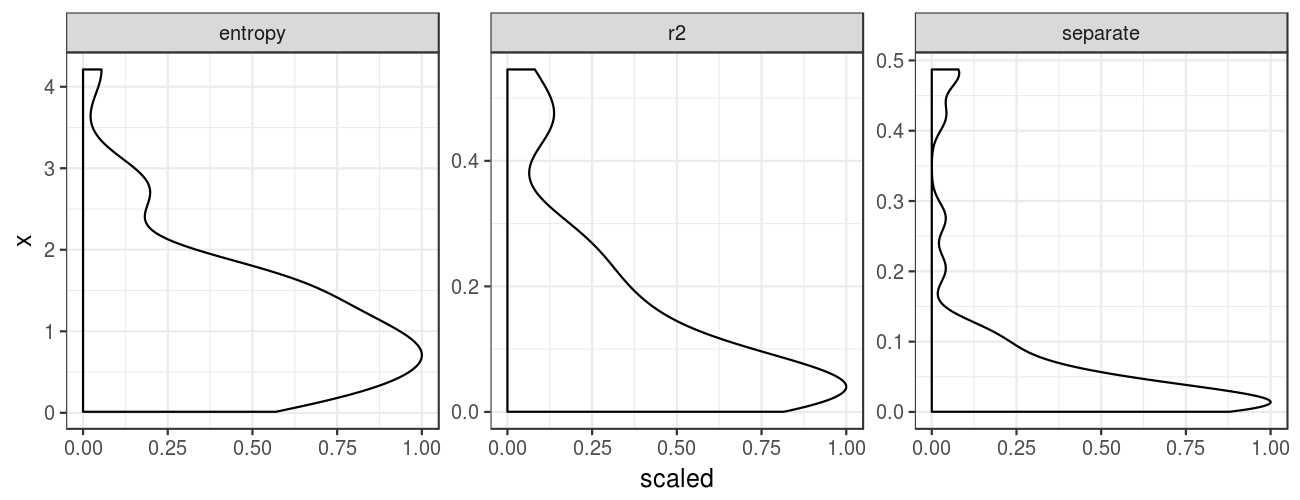

In [129]:
df = pd.concat([
    categ_vars_by_entropy.assign(method='entropy').rename(columns={'entropy': 'x'}),
    categ_vars_by_target_separation.assign(method='separate').rename(columns={'score': 'x'}),
    categ_vars_by_r2.assign(method='r2').rename(columns={'r2': 'x'})
])

with grdevices.render_to_bytesio(grdevices.png, width=1300, height=500, res=150) as img:
    g = ggplot2.ggplot(df) + \
    ggplot2.aes_string(x='x') + \
    ggplot2.geom_density(ggplot2.aes_string(y='..scaled..')) + \
    ggplot2.facet_wrap(robjects.Formula('~method'), nrow=1, scales = "free") + \
    ggplot2.coord_flip() + \
    ggplot2.theme_bw() + \
    print(g)

from IPython.display import Image, display
data = img.getvalue()
display(Image(data=data, format='png', embed=True))